In [1]:
from cube import Cube
from tile import Tile
from ck2map import CK2Map
from continent_gen import *
import random
from border_doodler import BorderDoodler
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

In [2]:
random_k_cols = [(np.random.randint(128, 256), 64, 64) for _ in range(300)]
random_d_cols = [(64,np.random.randint(128, 256), 64) for _ in range(300)]
random_c_cols = [(np.random.randint(64, 256),64,np.random.randint(64, 256)) for _ in range(300)]

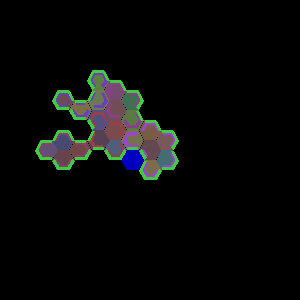

In [3]:
cd = make_capital_duchy(rgb_tuple=(random_d_cols.pop(), random_c_cols[:6]))
bd = BorderDoodler(cd, size=(300,300))
bd.im

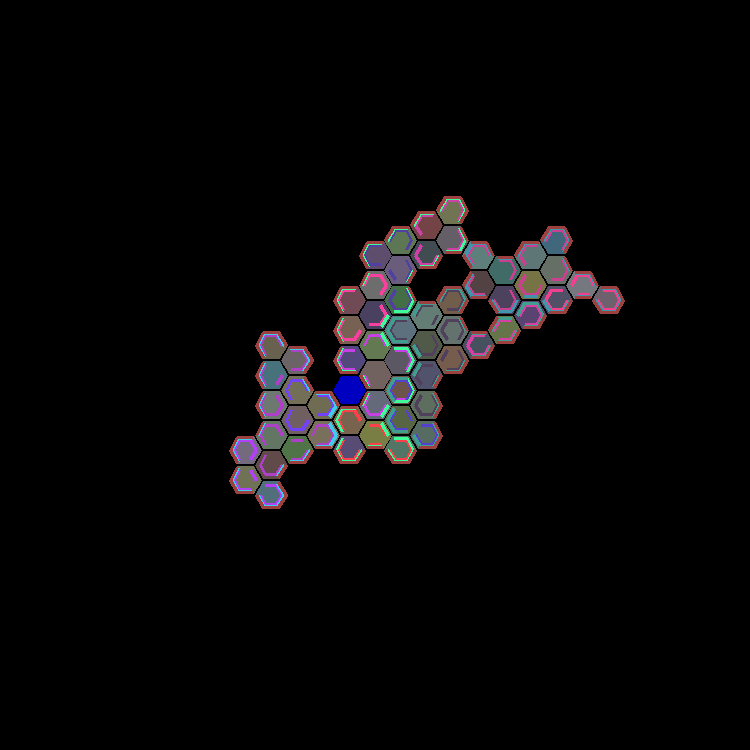

In [4]:
kingdom = make_kingdom()
bdk = BorderDoodler(kingdom, size=(750,750),radius=15)
bdk.im

In [2]:
import time

In [3]:
start_time = time.time()
continent, kingdoms = new_continent_gen(5)
end_time = time.time()
print(end_time-start_time)

Added 3 kingdoms!
Added 4 kingdoms!
Added 5 kingdoms!
{}
77.14322066307068


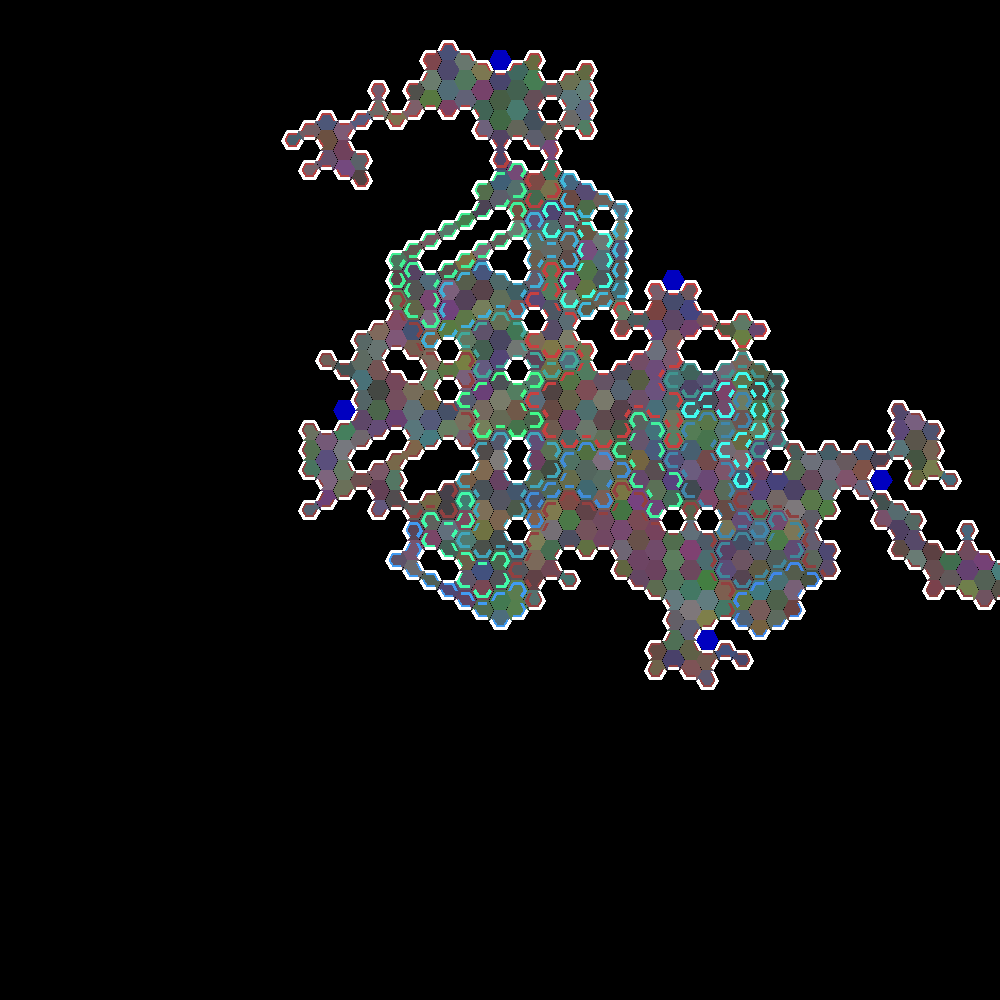

In [4]:
bdc = BorderDoodler(continent, size=(1000,1000),radius=10, depth=1)
bdc.im

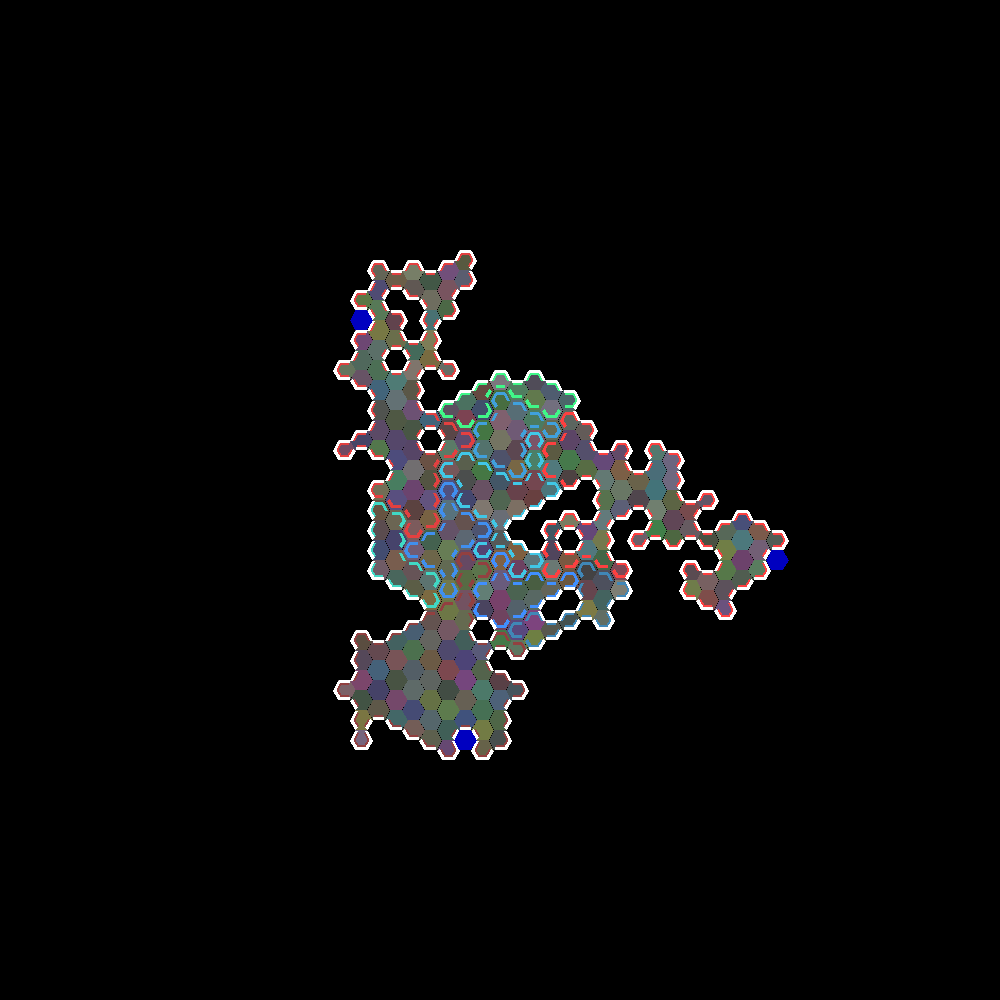

In [10]:
stripped = Tile(hex_list=[], tile_list=continent.tile_list[:-12])
bdc = BorderDoodler(stripped, size=(1000,1000),radius=10, depth=1)
bdc.im

In [13]:
stripped.tile_list.extend(continent.tile_list[-12].tile_list)
bdc = BorderDoodler(stripped, size=(1000,1000),radius=10, depth=1)

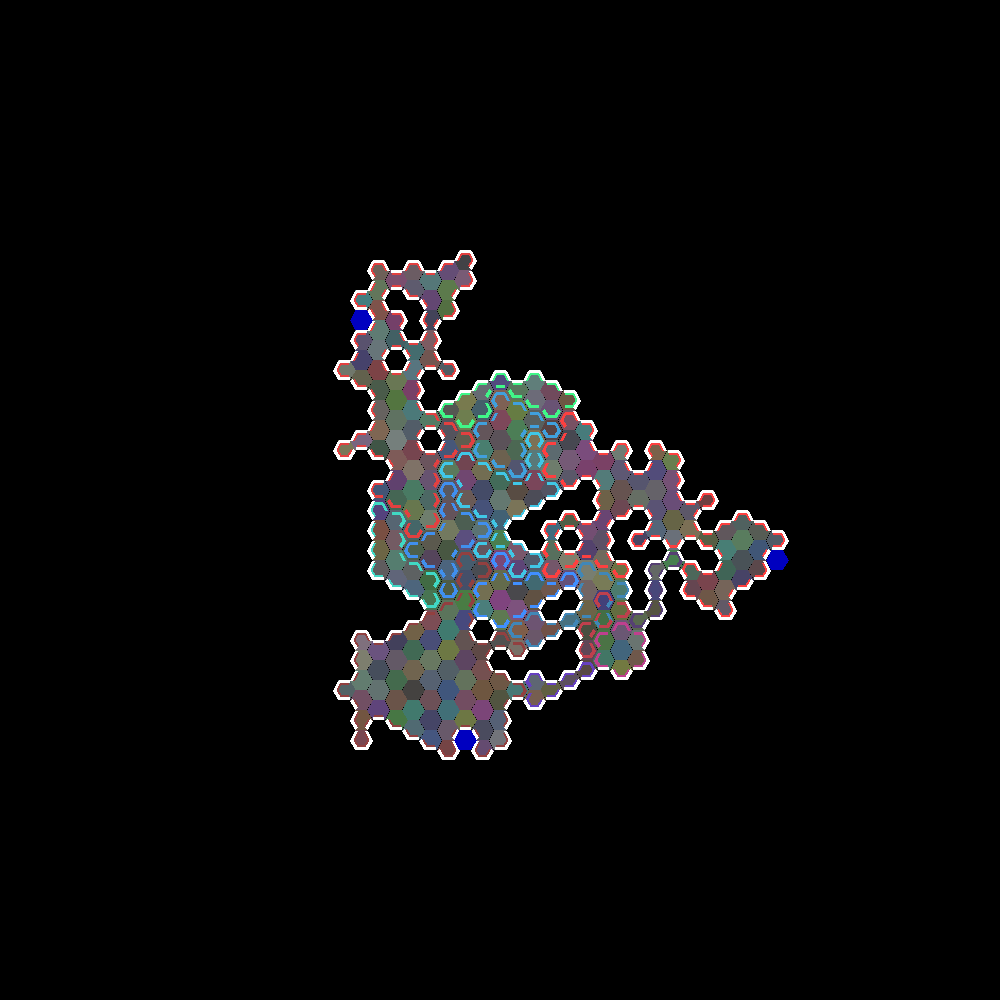

In [14]:
bdc.im

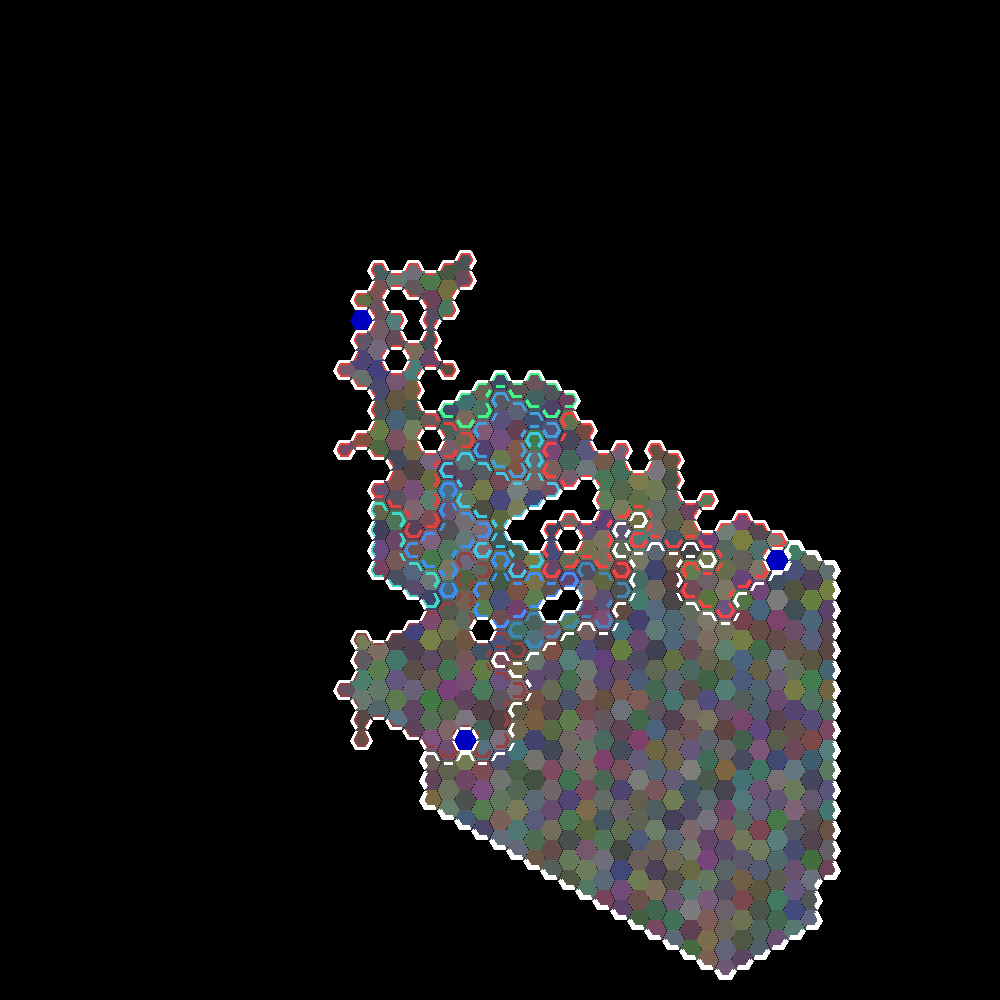

In [11]:
assigned = stripped.real_total_list()
c_idx = 3
k_dists = calculate_distances(kingdoms[:c_idx], assigned, sum(CENTER_SIZE_LIST) - 4)
border_tile = Tile(tile_list=[tel for tel in continent.tile_list if tel.size < sum([sum(sublist) for sublist in KINGDOM_SIZE_LIST])])
border_dists = calculate_distances(border_tile, assigned, sum(CENTER_SIZE_LIST) - 4)[0]
a_idx=0
b_idx=1
allowable = [el for el in k_dists[a_idx] if el in k_dists[b_idx]]
stripped.tile_list.append(Tile(hex_list=allowable))
bdc = BorderDoodler(stripped, size=(1000,1000),radius=10, depth=1)
stripped.tile_list.pop(-1)
bdc.im

In [19]:
chunk = allowable
ranking = {}
for el in allowable:
    ranking[el] = border_dists.get(el, el.mag())
poss_centers = sort_hexlist([el for el in chunk if all([nel in chunk for nel in el.neighbors()])], ranking)

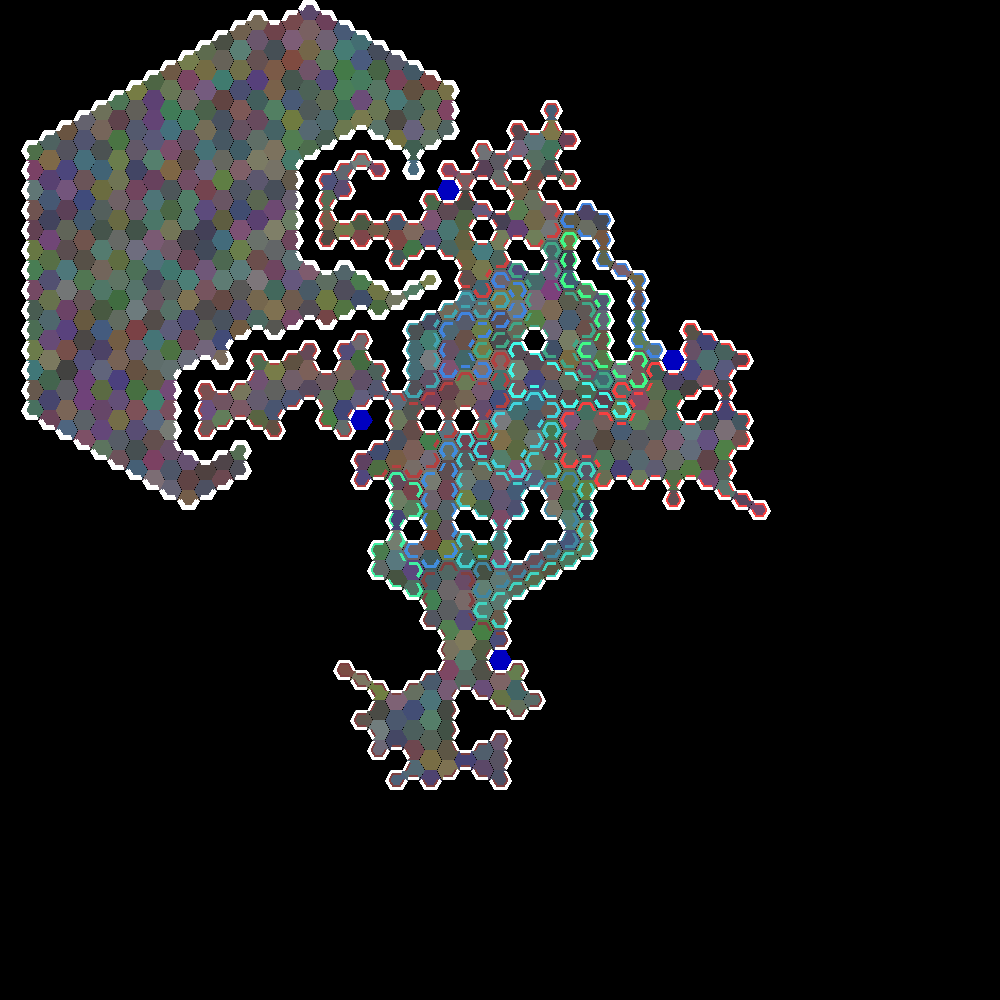

In [21]:
stripped.tile_list.append(Tile(hex_list=poss_centers))
bdc = BorderDoodler(stripped, size=(1000,1000),radius=10, depth=1)
stripped.tile_list.pop(-1)
bdc.im

In [21]:
def add_center_county(size, c_nbrs, adj, chunk):
    for outer_try_count in range(30):
        candidate = set()
        candidate.add(random.sample(c_nbrs, k=1)[0])
        candidate.add(random.sample(adj, k=1)[0])
        inner_try_count = 0
        while len(candidate) < size and inner_try_count < 20:
            pick = random.sample(candidate, k=1)[0]
            opts = [el for el in pick.neighbors() if el in chunk]
            if len(opts) >= 1:
                candidate.add(random.choice(opts))
        candidate = list(candidate)
        if len(get_chunks(candidate)) == 1:
            return Tile(hex_list=candidate, rgb=c_col())
    return False

def add_center_duchy(size_list, allowable_chunks, a_dist, b_dist, ranking):
    '''Given a list of necessary sizes (size_list), and a list of list of hexes (allowable_chunks), 
    attempt to create a center duchy, where counties are adjacent to both a and b (has a hex with 1 a_dist and 1 b_dist).
    Ranking is a dictionary of all (base) elements in allowable_chunks.
    Returns False if it doesn't find a solution in time.'''
    size = sum(size_list)
    while len(allowable_chunks) > 0:
        chunk = allowable_chunks.pop(0)
        if len(chunk) >= size:
            poss_centers = sort_hexlist([el for el in chunk if all([nel in chunk for nel in el.neighbors()])], ranking)
            a_adj = sort_hexlist([el for el in chunk if a_dist[el] == 1], ranking)
            b_adj = sort_hexlist([el for el in chunk if b_dist[el] == 1], ranking)
            for center in poss_centers:
                duchy = Tile(hex_list=[], tile_list=[make_capital_county(size_list[0], origin=center,coastal=False)], rgb=d_col())
                a_county = add_center_county(size_list[1], duchy.tile_list[0].neighbors(), a_adj, chunk)
                if a_county:
                    duchy.add_tile(a_county)
                else:
                    continue
                b_county = add_center_county(size_list[2], duchy.tile_list[0].neighbors(), b_adj, chunk)
                if b_county:
                    duchy.add_tile(b_county)
                else:
                    continue
                for _ in range(20):
                    try:
                        duchy.add_bordering_tile(size_list[3], rgb=c_col())
                        break
                    except:
                        continue
                return duchy
    return False

def inner_add_triangle(continent, kingdoms, c_idx):
    assigned = continent.real_total_list()
    k_dists = calculate_distances(kingdoms[:c_idx], assigned, sum(CENTER_SIZE_LIST) - 4)
    border_tile = Tile(tile_list=[tel for tel in continent.tile_list if tel.size < sum([sum(sublist) for sublist in KINGDOM_SIZE_LIST])])
    border_dists = calculate_distances(border_tile, assigned, sum(CENTER_SIZE_LIST) - 4)[0]
    for a_idx, b_idx in combinations(range(c_idx), r=2):
        print(f'Trying {a_idx}, {b_idx}')
        allowable = [el for el in k_dists[a_idx] if el in k_dists[b_idx]]
        # We shouldn't bother to try to place the center in a spot that doesn't have ocean access.
        center_chunks = []
        center_allowable = []
        a_adj = []
        b_adj = []
        for chunk in get_chunks(allowable):
            this_a_adj = [el for el in chunk if k_dists[a_idx][el] == 1]
            this_b_adj = [el for el in chunk if k_dists[b_idx][el] == 1]
            if (len(this_a_adj) > 0) and (len(this_b_adj) > 0) and check_water_access(assigned, [chunk[0]]):
                center_chunks.append(chunk)
                center_allowable.extend(chunk)
                a_adj.extend(this_a_adj)
                b_adj.extend(this_b_adj)
        if len(a_adj) == 0:
            continue
        ranking = {}
        for el in allowable:
            ranking[el] = border_dists.get(el, el.mag())
        need_center = True
        num_center_tries = 0
        while num_center_tries < 20 and need_center:
            print('num center tries', num_center_tries)
            num_center_tries += 1
            new_center = add_center_duchy(CENTER_SIZE_LIST, center_chunks, k_dists[a_idx], k_dists[b_idx], ranking)
            # new_center = make_capital_duchy(size_list=CENTER_SIZE_LIST)
            # need_center = not(new_center.move_into_place([a_adj, b_adj], assigned, []))
            if new_center:
                need_center = not check_water_access(assigned + new_center.real_hex_list(), continent.real_water_list())
        # if need_center:
        #     continue
            if not need_center:
                #Add the new center
                continent.add_tile(new_center)
                #Add the new kingdom
                cont_real = continent.real_hex_list()
                cen_nbrs = [el for el in continent.tile_list[-1].neighbors() if el not in cont_real]
                for kingdom_tries in range(15):
                    print('kingdom tries', kingdom_tries)
                    if move_kingdom_into_place(continent, kingdoms[c_idx], cen_nbrs):
                        temp_assigned = continent.real_total_list()
                        temp_k_dists = calculate_distances(kingdoms[:c_idx + 1], temp_assigned, sum(BORDER_SIZE_LIST))
                        ranking = calculate_distances(continent.tile_list[-2], temp_assigned, 8)[0] #Maybe this should just be mag?
                        #Add the 4 new border duchies.
                        allowable = [el for el in temp_k_dists[a_idx] if el in temp_k_dists[c_idx]]
                        a_ranking = dict([(el, ranking[el]) if el in ranking else (el, temp_k_dists[a_idx][el] + temp_k_dists[c_idx][el]) for el in allowable])
                        new_duchies = divide_into_duchies(BORDER_SIZE_LIST, 2, get_chunks(allowable), temp_k_dists[a_idx], temp_k_dists[c_idx], a_ranking)
                        if new_duchies:
                            continent.add_tile(new_duchies[0])
                            continent.add_tile(new_duchies[1])
                            allowable = [el for el in temp_k_dists[b_idx] if el in temp_k_dists[c_idx]]
                            b_ranking = dict([(el, ranking[el]) if el in ranking else (el, temp_k_dists[b_idx][el] + temp_k_dists[c_idx][el]) for el in allowable])
                            new_duchies = divide_into_duchies(BORDER_SIZE_LIST, 2, get_chunks(allowable), temp_k_dists[b_idx], temp_k_dists[c_idx], b_ranking)
                            if new_duchies:
                                continent.add_tile(new_duchies[0])
                                continent.add_tile(new_duchies[1])
                                cont_real = continent.real_hex_list()
                                radius = max([el.mag() for el in cont_real])
                                if check_water_access(cont_real, continent.real_water_list(), radius):
                                    return True
                                else:
                                    for _ in range(4):
                                        continent.tile_list.pop()
                            else:
                                for _ in range(2):
                                    continent.tile_list.pop()
                        continent.tile_list.pop() #Remove the kingdom that we added that we couldn't build duchies to.
                    else:
                        num_next_tries = 10 #If we fail at adding the kingdom, then we shouldn't try again.
                continent.tile_list.pop() #Remove the central duchy that we added but couldn't find a good kingdom for.
    return False

In [22]:
inner_add_triangle(continent, kingdoms, 3)

Trying 0, 1
num center tries 0
num center tries 1
num center tries 2
num center tries 3
num center tries 4
num center tries 5
num center tries 6
num center tries 7
num center tries 8
num center tries 9
num center tries 10
num center tries 11
num center tries 12
num center tries 13
num center tries 14
num center tries 15
num center tries 16
num center tries 17
num center tries 18
num center tries 19
Trying 0, 2
num center tries 0
kingdom tries 0
kingdom tries 1
kingdom tries 2


True

In [7]:
from PIL import Image, ImageDraw
size = (100,100)
im = Image.new('RGB', size, (0,0,0))
draw = ImageDraw.Draw(im)
radius = 10

def get_center(cube):
    assert cube.x + cube.y + cube.z == 0, f'bad cube {cube}'
    p = np.array(size) / 2
    p += cube.x * np.array([sqrt(3), -1]) * radius
    p += cube.y * np.array([0, -1]) * radius * 2
    return p

def get_hex_points(p, r=0):
    points = []
    for angle in range(0, 360, 60):
        theta = angle * np.pi / 180
        delta = np.array([np.cos(theta), np.sin(theta)]) * (radius+1-r)
        points.append(tuple(p + delta))
    return points

In [8]:
for nind, nbor in enumerate(Cube().ordered_neighbors()):
    hex_points = get_hex_points(get_center(nbor))
    # draw.polygon(hex_points, outline=(40+nind*10,0,0), fill=(nind*40,0,0))
    hex_points.append(hex_points[0])  # Wraparound.
    for ind in range(6):
        draw.line((hex_points[ind], hex_points[ind+1]),
        fill=(80+ind*20,0,0))

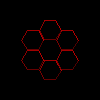

In [9]:
im

In [10]:
get_hex_points(get_center(Cube()))

[(61.0, 50.0),
 (55.5, 59.52627944162882),
 (44.5, 59.52627944162883),
 (39.0, 50.0),
 (44.49999999999999, 40.47372055837118),
 (55.5, 40.47372055837118)]

In [ ]:
for cube in cc.real_hex_list():
    center_pixel = 

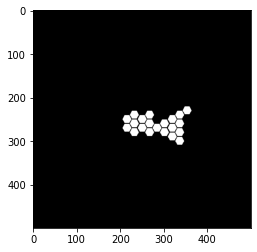

In [11]:

origin=Cube(0,0,0)
size_list = [[5,4,4,4,4], [4,4,3,3], [4,4,3,3], [4,4,3]]
kingdom = Tile(origin=origin, tile_list=[make_capital_duchy(size_list=size_list[0])], hex_list=[])
kingdom.doodle()

In [1]:
from math import sqrt
from PIL import Image, ImageDraw

In [ ]:
class TitleDoodler:
    def __init__(self, size=(500,500), radius=15):
        self.im = Image.new('RGB', size, (0, 0, 0))
        self.draw = ImageDraw.Draw(self.im)
        self.size = size
        self.radius = radius

    def get_center(self, cube):
        assert cube.x + cube.y + cube.z == 0, f'bad cube {cube}'
        p = np.array(self.size) / 2
        p += cube.x * np.array([sqrt(3), -1]) * self.radius
        p += cube.y * np.array([0, -1]) * self.radius * 2
        return p

    def get_hex_points(self, p, radius=None):
        radius = radius or self.radius
        points = []
        for angle in range(0, 360, 60):
            theta = angle * np.pi / 180
            delta = np.array([np.cos(theta), np.sin(theta)]) * radius
            points.append(tuple(p + delta))
        return points

    def draw_barony(self, cube, color):
        '''Return the '''
        self.draw.polygon(self.get_hex_points(self.get_center(cube)), fill=color)
        